# Signal transformation

Explore use of continuous wavelet transformation.

Source: https://github.com/taspinar/siml

In [1]:
import os
import pywt
import itertools
import numpy as np
import pandas as pd

from scipy.fftpack import fft
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

from scipy import signal

## Example: El-Nino

Source: https://github.com/taspinar/siml/blob/master/notebooks/WV2%20-%20Visualizing%20the%20Scaleogram%2C%20time-axis%20and%20Fourier%20Transform.ipynb

In [2]:
dataset = "https://raw.githubusercontent.com/taspinar/siml/master/datasets/sst_nino3.dat.txt"
df_nino = pd.read_table(dataset)
N = df_nino.shape[0]
t0=1871
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()

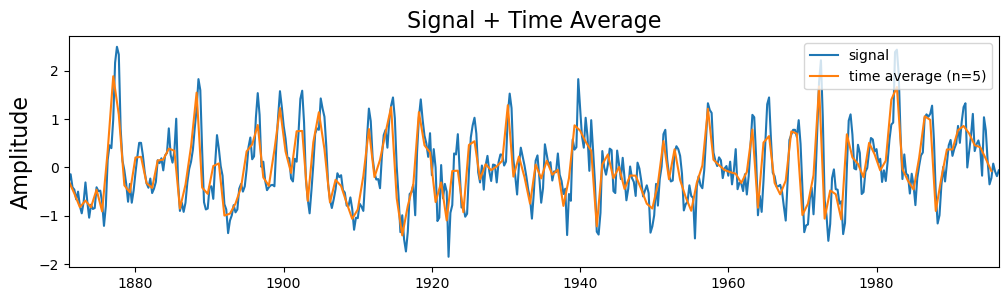

In [3]:
# First lets load the el-Nino dataset, and plot it together with its time-average

def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

def plot_signal_plus_average(ax, time, signal, average_over = 5):
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Amplitude', fontsize=16)
    ax.set_title('Signal + Time Average', fontsize=16)
    ax.legend(loc='upper right')

fig, ax = plt.subplots(figsize=(12,3))
plot_signal_plus_average(ax, time, signal, average_over = 3)
plt.show()

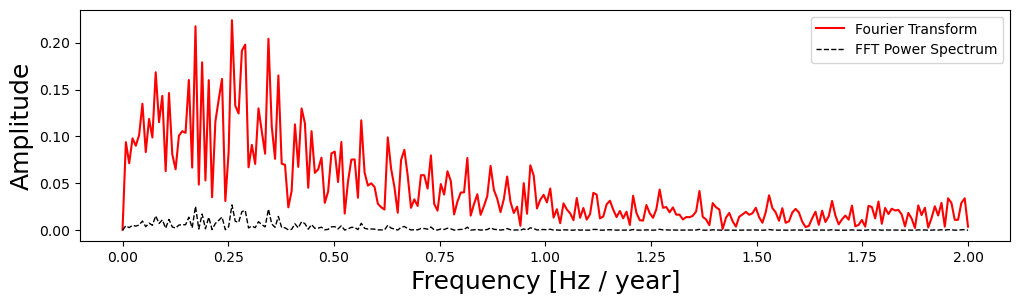

In [4]:
def get_fft_values(y_values, T, N, f_s):
    N2 = 2 ** (int(np.log2(N)) + 1) # round up to next highest power of 2
    f_values = np.linspace(0.0, 1.0/(2.0*T), N2//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N2 * np.abs(fft_values_[0:N2//2])
    return f_values, fft_values

def plot_fft_plus_power(ax, time, signal, plot_direction='horizontal', yticks=None, ylim=None):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2
    if plot_direction == 'horizontal':
        ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
        ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    elif plot_direction == 'vertical':
        scales = 1./f_values
        scales_log = np.log2(scales)
        ax.plot(fft_values, scales_log, 'r-', label='Fourier Transform')
        ax.plot(fft_power, scales_log, 'k--', linewidth=1, label='FFT Power Spectrum')
        ax.set_yticks(np.log2(yticks))
        ax.set_yticklabels(yticks)
        ax.invert_yaxis()
        ax.set_ylim(ylim[0], -1)
    ax.legend()

fig, ax = plt.subplots(figsize=(12,3))
ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
ax.set_ylabel('Amplitude', fontsize=18)
plot_fft_plus_power(ax, time, signal)
plt.show()

/home/amy/miniconda3/envs/ctg/lib/python3.10/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


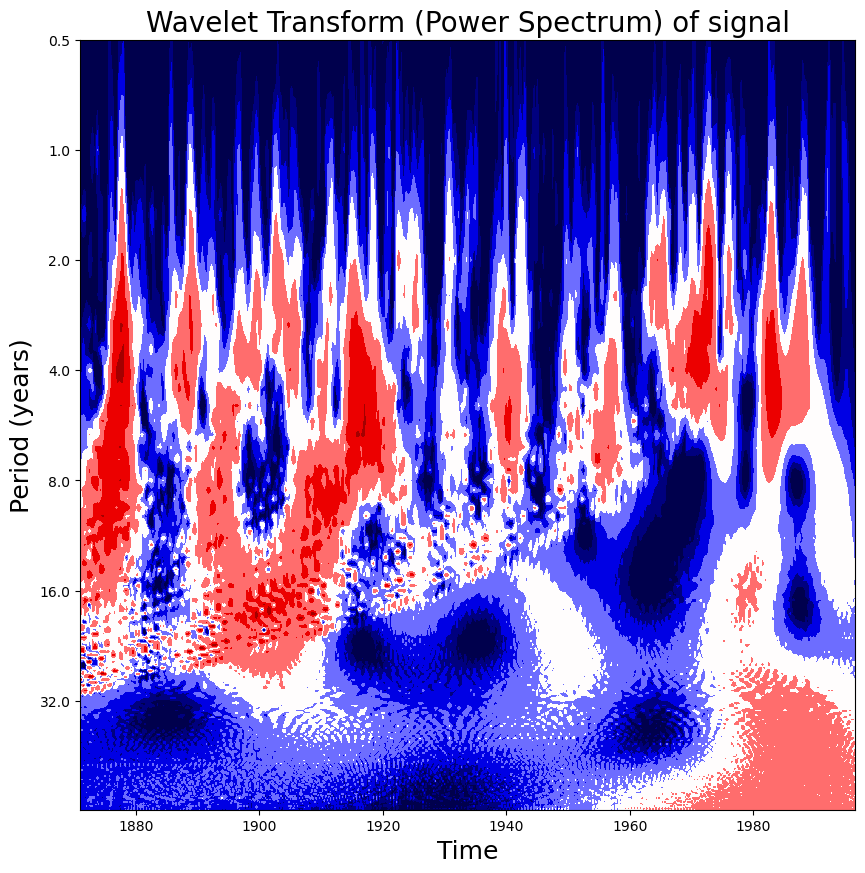

In [5]:
def plot_wavelet(ax, time, signal, scales, waveletname = 'cmor', 
                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    return yticks, ylim

scales = np.arange(1, 128)
title = 'Wavelet Transform (Power Spectrum) of signal'
ylabel = 'Period (years)'
xlabel = 'Time'

fig, ax = plt.subplots(figsize=(10, 10))
plot_wavelet(ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)
plt.show()

In both, you see that power is concentrated in a 2-8 year period.

In the CWT, you can also see that there were many fluctuations in 1870-1920, fewer in 1960-1990, and shift from shorter to longer periods as time progresses - you cannot see that in the Fourier transform.

## Applied: FHR signal 1001

In [6]:
from dataclasses import dataclass

In [7]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './data_csv'
    meta = 'metadata.csv'


paths = Paths()

In [8]:
# Set up dictionary for CSV files
csv_files = dict()

# Load files into dictionary
filenames = os.listdir(paths.data)
for file in filenames:
    # Get filename and file extension
    filename, file_extension = os.path.splitext(os.path.join(paths.data, file))
    # Load data and save to dict with filename (without path/csv) as index
    if file_extension == '.csv':
        filename_short = filename.split('/')[-1]
        csv_files[filename_short] = pd.read_csv(os.path.join(paths.data, file))

In [9]:
def clean_fhr(fhr):
    '''
    Cleans fetal heart rate (FHR) signal, and displays the signal before and
    after cleaning. Removes long periods of missing data, outliers and spikes,
    and uses linear interpolation to population remaining missing data.
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    Returns:
    clean_fhr - cleaned version of series
    '''
    # Show original trace
    fhr.plot(figsize=(15, 5))
    plt.show()

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(16) & na)].reset_index(drop=True)

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')
    fhr.plot(figsize=(15, 5))

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Show clean trace
    fhr.plot(figsize=(15, 5))
    plt.show()

    return(fhr)

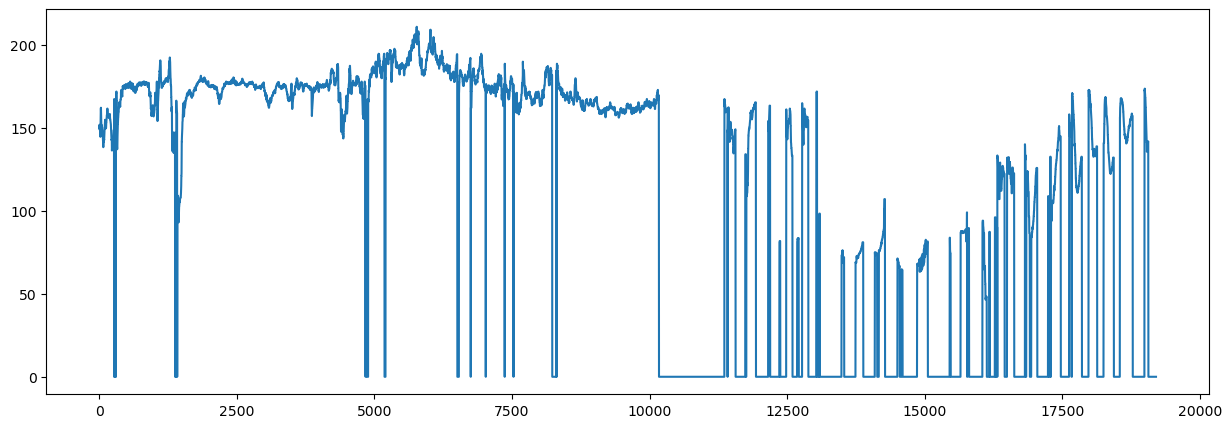

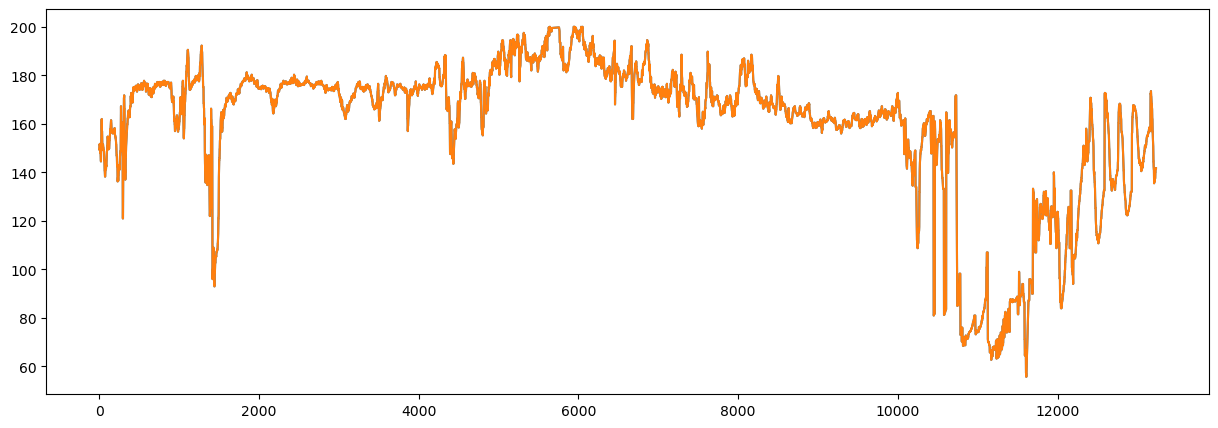

In [10]:
fhr = clean_fhr(csv_files['1291']['FHR'])

Transformations using PyWavelets

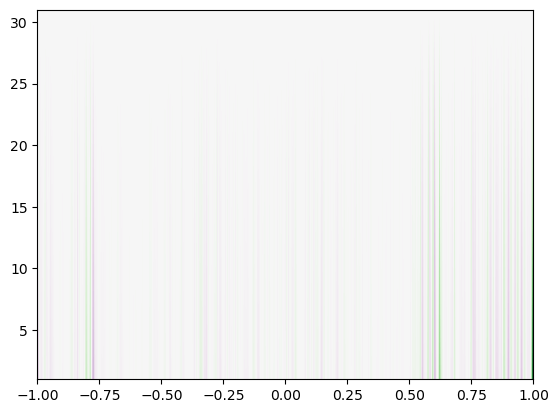

In [11]:
coef, freq = pywt.cwt(data=fhr, scales=np.arange(1, 31), wavelet='gaus1')

plt.imshow(
    coef,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(coef).max(),
    vmin=-abs(coef).max(),
);

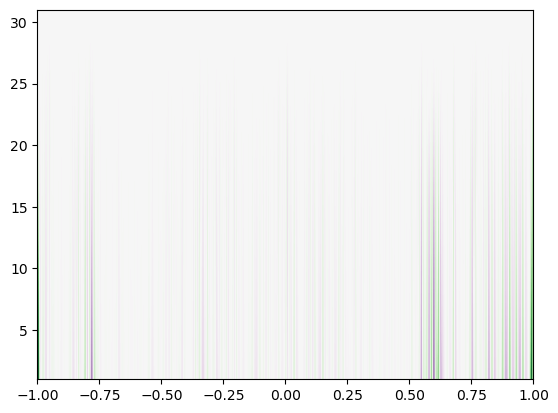

In [12]:
coef, freq = pywt.cwt(data=fhr, scales=np.arange(1, 31), wavelet='mexh')

plt.imshow(
    coef,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(coef).max(),
    vmin=-abs(coef).max(),
);

Transformation using SciPy

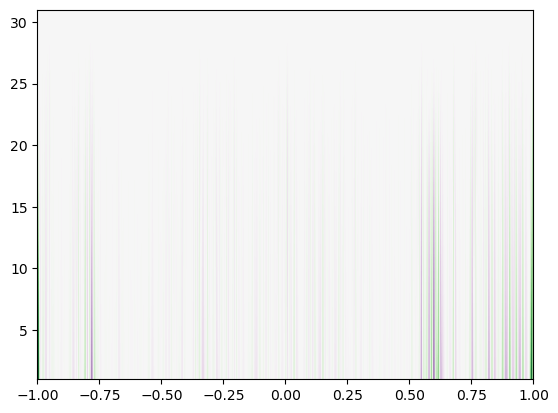

In [13]:
from scipy import signal
cwtmatr = signal.cwt(fhr, signal.ricker, np.arange(1, 31))

plt.imshow(
    cwtmatr,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(cwtmatr).max(),
    vmin=-abs(cwtmatr).max(),
);

Taking real and imaginary components - https://www.kaggle.com/code/anjum48/continuous-wavelet-transform-cwt-in-pytorch

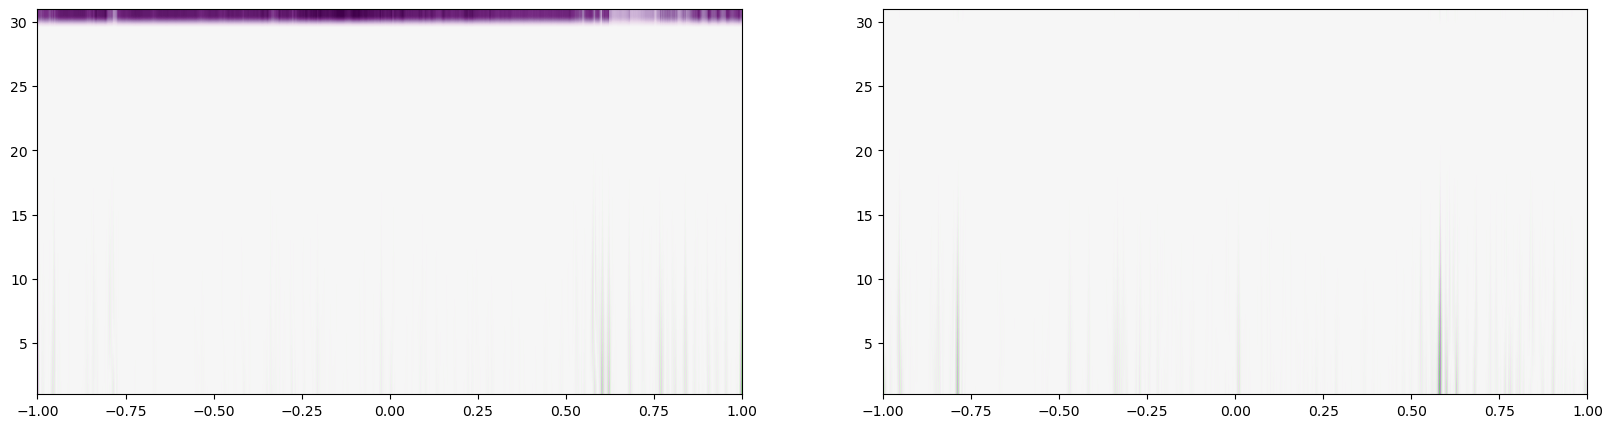

In [14]:
cwtmatr = signal.cwt(fhr, signal.morlet2, np.arange(1, 31))

real, imag = np.real(cwtmatr), np.imag(cwtmatr)

# Plot the real & imaginary components after CWT using a complex Morlet wavelet
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
axes[0].imshow(
    real,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(real).max(),
    vmin=-abs(real).max(),
)
axes[1].imshow(
    imag,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(imag).max(),
    vmin=-abs(imag).max(),
);

(30, 13234)


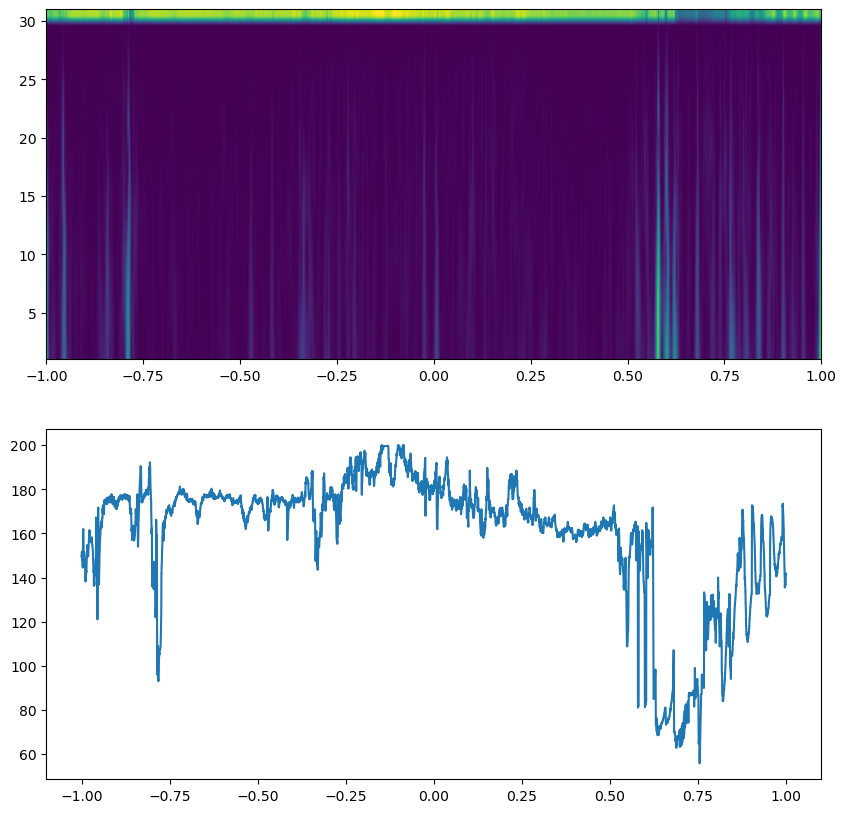

In [15]:
# Plot the magnitude with the raw signal
magn = np.absolute(cwtmatr)
print(magn.shape)
fig, axes = plt.subplots(nrows=2, figsize=(10, 10))
axes[0].imshow(
    magn,
    extent=[-1, 1, 1, 31],
    aspect="auto",
)
t = np.linspace(-1, 1, 13234, endpoint=False)
axes[1].plot(t, fhr);